<a href="https://colab.research.google.com/github/NataliaBlueCloud/rtt_latency_analysis_triangle_violations/blob/main/RTT_global_ping_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛰️ Global Triangle Inequality Violation (TIV) Analysis Using WonderNetwork RTT Data

This notebook reproduces the analysis and visualization of global RTT measurements from the WonderNetwork dataset.
It loads the 2025 measurements, removes outliers, computes average RTT per country, and plots server locations with labeled regional codes (e.g., n₁, we₂, ee₁).

### 1. Clone the Repository
Clone the GitHub repository containing RTT measurement data and helper scripts.


In [7]:
system('git clone https://github.com/NataliaBlueCloud/rtt_latency_analysis_triangle_violations.git')

### 2. Install Required Packages

Install all the R libraries used for data handling, visualization, and map generation.
Run this block only once per session.

In [2]:
install.packages("igraph")
install.packages("R.utils")
install.packages("sf")
install.packages("rnaturalearth")
install.packages("rnaturalearthdata")
install.packages("dplyr")
install.packages("ggrepel")
install.packages("tidyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘R.oo’, ‘R.methodsS3’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘s2’, ‘units’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘terra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### 3. Load Libraries

Load all required R libraries.
These provide functionality for data tables, graphs, geospatial analysis, and plotting.

In [8]:
library(data.table)
library(igraph)
library(ggplot2)
library(R.utils)
library(readxl)
library(sf)
library(rnaturalearth)
library(rnaturalearthdata)
library(dplyr)
library(ggrepel)
library(tidyr)

### 4. Load RTT and Server Datasets

Load the list of servers and the RTT dataset for January 1, 2025.
Each record represents a Ping measurement between two server locations.

In [9]:
# Load the servers dataset
servers <- fread("/content/rtt_latency_analysis_triangle_violations/Input_files/servers-2020-07-19.csv")

# Load data
names_df <- c("source", "destination", "timestamp", "min", "avg", "max", "mdev")
# Corrected file path to use the existing 2025-01-01.csv.gz
df <- fread("/content/rtt_latency_analysis_triangle_violations/Input_files/2025-01-01.csv.gz")
names(df) <- names_df

# Merge with server names to replace IDs with names
df <- merge(df, servers, by.x = "source", by.y = "id")
df <- merge(df, servers, by.x = "destination", by.y = "id", suffixes = c("_src", "_dst"))

# Create a unique list of node names
city_ids <- servers$id
city_names <- servers$name

### 5. Remove Outliers Using IQR Method

Filter out extreme RTT values to eliminate transient anomalies or measurement errors.
This uses the Inter-Quartile Range (IQR) per (source, destination) pair.

In [10]:
# Remove outliers in the 'avg' column using IQR method
# Calculate IQR bounds
# Identify outliers per (source, destination) group
# Function to remove outliers using IQR
initial_n <- nrow(df)

remove_outliers <- function(data) {
  q1 <- quantile(data$avg, 0.25, na.rm = TRUE)
  q3 <- quantile(data$avg, 0.75, na.rm = TRUE)
  iqr <- q3 - q1
  #lower <- q1 - 1000 * iqr #no need the lower
  upper <- q3 + 10000 * iqr
  data[data$avg <= upper]

}

# Apply outlier removal per (source, destination) pair
cleaned_df <- df[, remove_outliers(.SD), by = .(source, destination)]

# Preview the cleaned dataset
head(cleaned_df)

final_n <- nrow(cleaned_df)

# Compute how many were removed
removed_n <- initial_n - final_n
cat("Number of outliers removed:", removed_n, "\n")

# Preview the cleaned dataset
head(cleaned_df)
df = cleaned_df

source,destination,timestamp,min,avg,max,mdev,name_src,title_src,location_src,⋯,longitude_src,name_dst,title_dst,location_dst,state_dst,country_dst,state_abbv_dst,continent_dst,latitude_dst,longitude_dst
<int>,<int>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
0,0,2025-01-01 00:22:39,0.020,0.033,0.102,0.016,JoaoPessoa,Joao Pessoa,Patos,⋯,-34.8333,JoaoPessoa,Joao Pessoa,Patos,Paraiba,Brazil,PB,2,-7.0833,-34.8333
0,0,2025-01-01 01:22:39,0.020,0.039,0.183,0.028,JoaoPessoa,Joao Pessoa,Patos,⋯,-34.8333,JoaoPessoa,Joao Pessoa,Patos,Paraiba,Brazil,PB,2,-7.0833,-34.8333
0,0,2025-01-01 02:22:39,0.019,0.024,0.046,0.007,JoaoPessoa,Joao Pessoa,Patos,⋯,-34.8333,JoaoPessoa,Joao Pessoa,Patos,Paraiba,Brazil,PB,2,-7.0833,-34.8333
0,0,2025-01-01 03:22:40,0.019,0.030,0.156,0.024,JoaoPessoa,Joao Pessoa,Patos,⋯,-34.8333,JoaoPessoa,Joao Pessoa,Patos,Paraiba,Brazil,PB,2,-7.0833,-34.8333
0,0,2025-01-01 04:22:39,0.018,0.029,0.045,0.009,JoaoPessoa,Joao Pessoa,Patos,⋯,-34.8333,JoaoPessoa,Joao Pessoa,Patos,Paraiba,Brazil,PB,2,-7.0833,-34.8333
0,0,2025-01-01 05:22:40,0.020,0.035,0.141,0.021,JoaoPessoa,Joao Pessoa,Patos,⋯,-34.8333,JoaoPessoa,Joao Pessoa,Patos,Paraiba,Brazil,PB,2,-7.0833,-34.8333


Number of outliers removed: 14 


source,destination,timestamp,min,avg,max,mdev,name_src,title_src,location_src,⋯,longitude_src,name_dst,title_dst,location_dst,state_dst,country_dst,state_abbv_dst,continent_dst,latitude_dst,longitude_dst
<int>,<int>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
0,0,2025-01-01 00:22:39,0.020,0.033,0.102,0.016,JoaoPessoa,Joao Pessoa,Patos,⋯,-34.8333,JoaoPessoa,Joao Pessoa,Patos,Paraiba,Brazil,PB,2,-7.0833,-34.8333
0,0,2025-01-01 01:22:39,0.020,0.039,0.183,0.028,JoaoPessoa,Joao Pessoa,Patos,⋯,-34.8333,JoaoPessoa,Joao Pessoa,Patos,Paraiba,Brazil,PB,2,-7.0833,-34.8333
0,0,2025-01-01 02:22:39,0.019,0.024,0.046,0.007,JoaoPessoa,Joao Pessoa,Patos,⋯,-34.8333,JoaoPessoa,Joao Pessoa,Patos,Paraiba,Brazil,PB,2,-7.0833,-34.8333
0,0,2025-01-01 03:22:40,0.019,0.030,0.156,0.024,JoaoPessoa,Joao Pessoa,Patos,⋯,-34.8333,JoaoPessoa,Joao Pessoa,Patos,Paraiba,Brazil,PB,2,-7.0833,-34.8333
0,0,2025-01-01 04:22:39,0.018,0.029,0.045,0.009,JoaoPessoa,Joao Pessoa,Patos,⋯,-34.8333,JoaoPessoa,Joao Pessoa,Patos,Paraiba,Brazil,PB,2,-7.0833,-34.8333
0,0,2025-01-01 05:22:40,0.020,0.035,0.141,0.021,JoaoPessoa,Joao Pessoa,Patos,⋯,-34.8333,JoaoPessoa,Joao Pessoa,Patos,Paraiba,Brazil,PB,2,-7.0833,-34.8333


### 6. Compute Average RTT per Country

Compute the mean RTT for each country (considering both source and destination measurements).
This provides an overall latency profile per geographic area.

In [11]:
country_avg_rtt <- df[, .(Avg_RTT = mean(avg, na.rm=TRUE), latitude=first(latitude_src), longitude=first(longitude_src)), by=country_src]
setnames(country_avg_rtt, "country_src", "country")

country_avg_rtt_dst <- df[, .(Avg_RTT = mean(avg, na.rm=TRUE), latitude=first(latitude_dst), longitude=first(longitude_dst)), by=country_dst]
setnames(country_avg_rtt_dst, "country_dst", "country")

# Merge both source and destination RTTs
country_avg_rtt <- rbind(country_avg_rtt, country_avg_rtt_dst)[, .(Avg_RTT = mean(Avg_RTT, na.rm=TRUE), latitude=first(latitude), longitude=first(longitude)), by=country]

# Load world map
the_world <- ne_countries(scale = "medium", returnclass = "sf")

### 7. Merge RTT Data with World Map

Prepare the world map for plotting.
Fix country name mismatches (e.g., “Czech Republic” → “Czechia”) and merge with RTT statistics.

In [12]:
missing_countries <- setdiff(country_avg_rtt$country, the_world$name)
print("Missing countries not found in world map:")
print(missing_countries)

country_avg_rtt[country == "Czech Republic", country := "Czechia"]
country_avg_rtt[country == "United States", country := "United States of America"]

world_map_data <- merge(the_world, country_avg_rtt, by.x = "name", by.y = "country", all.x = TRUE)

[1] "Missing countries not found in world map:"
[1] "Czech Republic" "United States" 


### 8. Assign Region Codes

Classify each country into broader regions
(e.g., n = North America, we = Western Europe, ee = Eastern Europe, etc.).

In [13]:
assign_region <- function(country) {
  if (country %in% c("United States", "Canada", "Mexico", "Puerto Rico", "Guatemala", "Panama", "Honduras", "Costa Rica"))
    return("n")
  if (country %in% c("United Kingdom", "France", "Germany", "Spain", "Greece", "Italy", "Netherlands",
                     "Belgium", "Switzerland", "Austria", "Sweden", "Norway", "Finland", "Denmark",
                     "Ireland", "Portugal", "Luxembourg", "Iceland", "Malta", "Isle of Man"))
    return("we")
  if (country %in% c("Poland", "Czech Republic", "Hungary", "Romania", "Bulgaria", "Slovakia",
                     "Croatia", "Serbia", "Ukraine", "Lithuania", "Latvia", "Estonia",
                     "Slovenia", "Kosovo", "Moldova", "Russia", "Georgia", "Albania"))
    return("ee")
  if (country %in% c("Australia", "New Zealand"))
    return("az")
  if (country %in% c("Brazil", "Argentina", "Chile", "Colombia", "Peru", "Uruguay",
                     "Ecuador", "Venezuela", "Suriname"))
    return("la")
  if (country %in% c("South Africa", "Egypt", "Nigeria", "Kenya", "Morocco", "Algeria",
                     "Tunisia", "Tanzania", "Ghana", "Uganda"))
    return("af")
  if (country %in% c("United Arab Emirates", "Saudi Arabia", "Israel", "Qatar", "Turkey", "Oman",
                     "Kuwait", "Lebanon", "Cyprus"))
    return("me")
  if (country %in% c("India", "Pakistan", "Bangladesh"))
    return("hi")
  if (country %in% c("Japan", "Singapore", "Malaysia", "Indonesia", "China", "Thailand",
                     "Vietnam", "Philippines", "South Korea", "Cambodia", "Taiwan", "Hong Kong", "Kazakhstan"))
    return("as")
  return(NA)
}


### 9. Label Servers per Region

Assign server labels using the format region_index (e.g., n₁, we₂).
This makes each node easily identifiable on the map

In [14]:
servers$region_code <- sapply(servers$country, assign_region)

# Add incremental labels (n_1, we_1, etc.)
servers <- servers %>%
  group_by(region_code) %>%
  mutate(server_label = paste0(region_code, "_", row_number())) %>%
  ungroup()


### 10. Reduce Label Clutter for Dense Regions

Limit the number of displayed labels in very dense regions
(North America, Western Europe) to keep the plot readable.

In [15]:
# Show every 2nd or 3rd label depending on region density
servers_labelled <- servers %>%
  group_by(region_code) %>%
  mutate(show_label = ifelse(region_code %in% c("n", "we"), row_number() %% 3 == 0, TRUE)) %>%
  filter(show_label)

### 11. Plot World Map with RTT and Server Labels

Visualize the average RTT per country with server positions and region labels.
Color = average RTT, Labels = regional server codes.

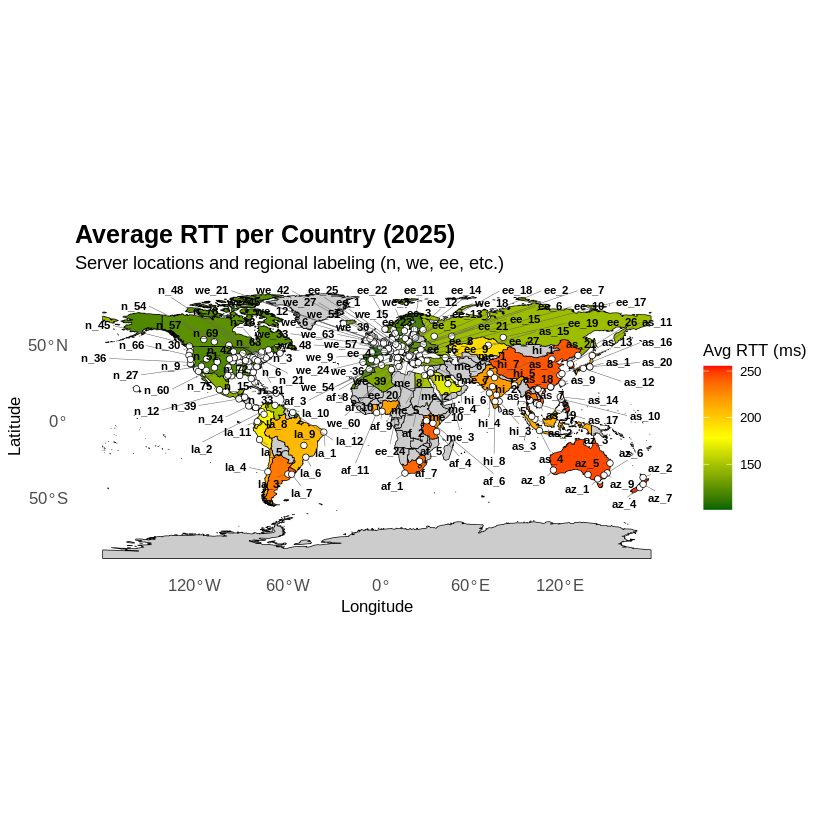

In [16]:
ggplot() +
  geom_sf(data = world_map_data, aes(fill = Avg_RTT), color = "black", size = 0.2) +

  # Server points
  geom_point(data = servers, aes(x = longitude, y = latitude),
             color = "black", fill = "white", size = 1.6, shape = 21, stroke = 0.3) +

  # Smart labels
  geom_text_repel(
    data = servers_labelled,
    aes(x = longitude, y = latitude, label = server_label),
    size = 2.4, fontface = "bold", color = "black",
    segment.size = 0.15, segment.color = "gray40",
    box.padding = 0.25, point.padding = 0.15,
    max.overlaps = 150, min.segment.length = 0
  ) +

  scale_fill_gradientn(colors = c("darkgreen", "yellow", "red"), na.value = "grey80") +

  labs(
    title = "Average RTT per Country (2025)",
    subtitle = "Server locations and regional labeling (n, we, ee, etc.)",
    x = "Longitude", y = "Latitude",
    fill = "Avg RTT (ms)"
  ) +

  theme_minimal(base_size = 10) +
  theme(
    panel.grid = element_blank(),
    axis.text = element_text(size = 10),
    plot.title = element_text(face = "bold", size = 15),
    plot.subtitle = element_text(size = 11)
  )


# ⚡ Triangle Inequality Violation (TIV) Detection and Analysis

This section builds a full-mesh latency graph from the 2025 RTT data, detects Triangle Inequality Violations (TIVs) using Dijkstra’s shortest-path algorithm, and computes the percentage and average gain from detour paths.

In [17]:
##########################################################
# Initialize adjacency matrix with Inf (no direct connection)
adj_matrix <- matrix(Inf, nrow = length(city_names), ncol = length(city_names))
rownames(adj_matrix) <- city_names
colnames(adj_matrix) <- city_names


# # Fill adjacency matrix with average latencies
src_num = 0
for(src in servers$id){
  dst_num = 0
  src_num = src_num + 1
  for(dst in servers$id){
    dst_num = dst_num + 1
    latency = mean(df$avg[df$source == src & df$destination == dst])
    adj_matrix[src_num, dst_num] <- latency
  }
}

### 1. Build the Adjacency Matrix

Construct a full adjacency matrix of average RTT values between all pairs of servers.
Each cell
(𝑖,𝑗) contains the mean RTT from server i to server j.

In [18]:
# Convert NaN or missing values to Inf and process values
adj_matrix_withoutNaN <- apply(adj_matrix, c(1,2), function(x) {
  if (is.nan(x) || is.na(x)) {  # Use is.nan() and is.na() to handle NaN and NA properly
    return(Inf)
  } else {
    return(x)
  }
})

### 2. Handle Missing or NaN Values

Replace missing or undefined RTTs with Inf, ensuring that the graph construction step interprets them as “no link.”

In [19]:
# Create a graph from the adjacency matrix
graph <- graph_from_adjacency_matrix(adj_matrix_withoutNaN, mode = "directed", weighted = TRUE)

### 3. Create the Graph Object

Transform the adjacency matrix into a directed, weighted graph using the igraph package.
Each vertex is a server, and each edge weight is the mean RTT.

### 4. Find Shortest (Detour) Paths and Detect TIVs

For each source–destination pair, compute the direct RTT and the shortest alternative path using Dijkstra’s algorithm.
If the detour path has a lower total RTT, record it as a TIV.

In [ ]:
# Empty results table with correct column types
alternative_paths <- data.frame(
  From = character(),
  To = character(),
  Direct = numeric(),
  Alternative = numeric(),
  Improvement = numeric(),
  Alternative_path = character(),
  TIV_present = logical(),
  stringsAsFactors = FALSE
)

# Loop over source/destination pairs
for (i in seq_along(city_names)) {
  for (j in seq_along(city_names)) {
    if (i == j) next

    direct_path <- adj_matrix_withoutNaN[i, j]  # may be NA

    # Dijkstra shortest path
    sp <- igraph::shortest_paths(
      graph,
      from = city_names[i],
      to   = city_names[j],
      weights = igraph::E(graph)$weight
    )

    if (length(sp$vpath[[1]]) > 0) {
      # Sum weights along the path
      sp_weight <- sum(igraph::E(graph, path = sp$vpath[[1]])$weight, na.rm = TRUE)

      # Is the alternative better than the direct edge?
      is_better <- is.finite(direct_path) && !is.na(direct_path) && (sp_weight < direct_path)

      # Nice printable path string
      path_str <- paste(as.character(sp$vpath[[1]]), collapse = " ")

      # Add one row
      alternative_paths <- rbind(
        alternative_paths,
        data.frame(
          From = city_names[i],
          To = city_names[j],
          Direct = direct_path,
          Alternative = if (is_better) sp_weight else NA_real_,
          Improvement = if (is_better) (direct_path - sp_weight) else NA_real_,
          Alternative_path = if (is_better) path_str else NA_character_,
          TIV_present = is_better,
          stringsAsFactors = FALSE
        )
      )

      if (is_better) {
        cat("Alternative path found:", city_names[i], "->", city_names[j],
            "via", path_str, "with latency", sp_weight,
            "ms (Direct:", direct_path, "ms)\n")
      }
    }
  }
}

# Display alternative paths
alternative_paths

### 5. Filter Invalid Entries and Compute TIV Statistics

Remove pairs without valid direct RTTs and calculate the percentage of optimized links (i.e., TIV links) and non-optimized ones.

In [21]:
# Display alternative paths
alternative_paths$TIV_gain <- (alternative_paths$Direct - alternative_paths$Alternative) /
  alternative_paths$Alternative * 100

alternative_paths_all_data <- alternative_paths
alternative_paths_TIV_df <- alternative_paths[(alternative_paths$TIV_present == 1), ]
percent_optimized <- (nrow(alternative_paths_TIV_df) / (length(city_names) * (length(city_names) - 1))) * 100

alternative_paths_TIV_df

,From,To,Direct,Alternative,Improvement,Alternative_path,TIV_present,TIV_gain
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>
1,JoaoPessoa,Melbourne,294.23771,287.63688,6.600833,1 15 74 38 99 2,TRUE,2.2948495
2,JoaoPessoa,Toronto,112.87850,95.31675,17.561750,1 164 95 3,TRUE,18.4246211
3,JoaoPessoa,Prague,187.69588,172.50750,15.188375,1 164 151 4,TRUE,8.8044723
4,JoaoPessoa,Paris,190.58971,152.95171,37.638000,1 164 5,TRUE,24.6077670
5,JoaoPessoa,Tokyo,251.22554,225.76121,25.464333,1 164 127 130 6,TRUE,11.2793219
6,JoaoPessoa,Amsterdam,177.73004,156.38700,21.343042,1 164 7,TRUE,13.6475805
7,JoaoPessoa,Auckland,275.95983,267.39546,8.564375,1 15 8,TRUE,3.2028872
8,JoaoPessoa,Moscow,215.93200,192.69475,23.237250,1 164 13 44 9,TRUE,12.0590987
9,JoaoPessoa,Stockholm,190.47450,171.35692,19.117583,1 164 13 10,TRUE,11.1565869


### 6. Compute TIV Gain (% Latency Reduction)

For each pair of servers $(i,j)$, the **Triangle Inequality Violation (TIV) gain** is defined as  
the relative improvement between the direct latency and the best detour path latency.

The metric quantifies how much faster an indirect path can be compared to the direct route:

$$
G(i,j) = \frac{d(i,j) - d_{\text{detour}}(i,j)}{d_{\text{detour}}(i,j)} \times 100\%
$$

where:

- $d(i,j)$ — average RTT measured directly between nodes *i* and *j*  
- $d_{\text{detour}}(i,j)$ — total RTT of the shortest indirect (multi-hop) path  

A positive $G(i,j)$ indicates a TIV case — i.e., the detour path provides a lower latency than the direct connection.



In [22]:
# Display alternative paths
alternative_paths$TIV_gain <- (alternative_paths$Direct - alternative_paths$Alternative) /
  alternative_paths$Alternative * 100

avg_TIV_gain <- mean(alternative_paths_TIV_df$TIV_gain)
avg_improvement <- mean(alternative_paths_TIV_df$Improvement)
# Print stats
cat("Percentage of optimized paths:", percent_optimized, "%\n")
cat("Average improvement in RTT:", avg_improvement, "ms\n")


Percentage of optimized paths: 72.28638 %
Average improvement in RTT: 20.73471 ms


### 7. Aggregate TIV Results by Country and City

Combine TIV statistics with geographic data for visualization.

In [23]:
combined_data = alternative_paths_TIV_df

# Merge with server data to get city names and coordinates
combined_data <- merge(combined_data, servers, by.x="From", by.y="name")

# Aggregate RTT improvement by country
country_rtt <- aggregate(Improvement ~ country, data=combined_data, mean)
city_rtt <- aggregate(Improvement ~ From, data=combined_data, mean)


### 8. Visualize Average TIV Gain per City

Plot the average percentage TIV gain per server location.
The color scale indicates the magnitude of improvement.

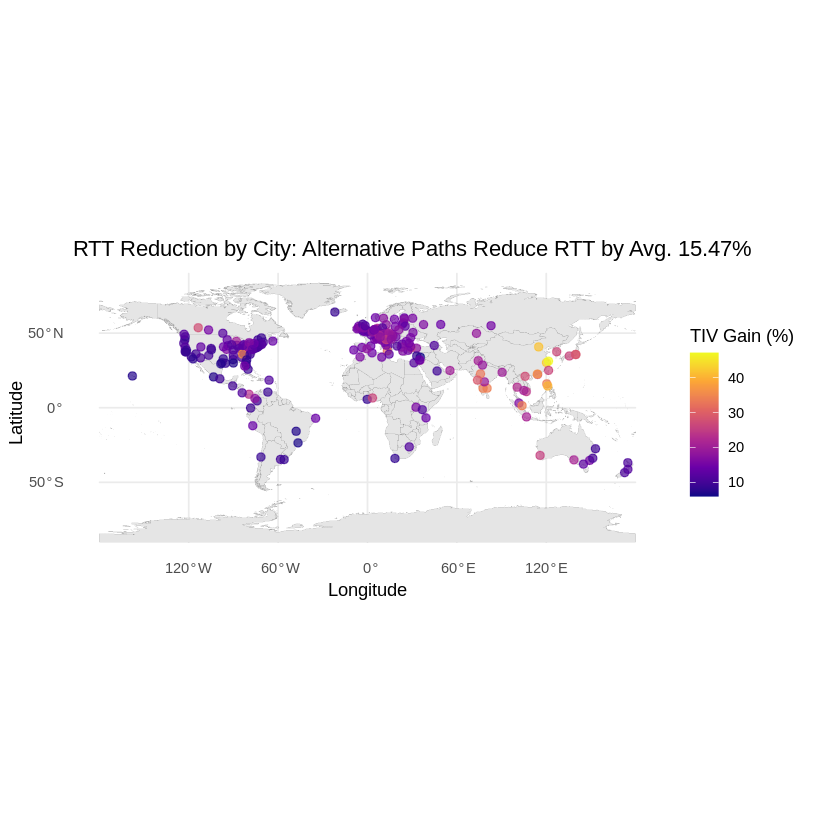

In [24]:
# Aggregate improvement percentage by city
city_rtt <- aggregate(TIV_gain ~ From, data=combined_data, mean)

# Merge with server locations
city_rtt <- merge(city_rtt, servers, by.x="From", by.y="name")

# Load world map
the_world <- ne_countries(scale = "medium", returnclass = "sf")

# Construct dynamic title with mean improvement percentage
mean_improvement <- round(mean(city_rtt$TIV_gain, na.rm=TRUE), 2)
title_text <- paste0("RTT Reduction by City: Alternative Paths Reduce RTT by Avg. ", mean_improvement, "%")

#v2 without size legend
# Plot RTT improvements by city with fixed, smaller point size and no size legend
ggplot() +
  geom_sf(data = the_world, fill = "grey90", color = "black", size = 0.02) +
  geom_point(data = city_rtt, aes(x = longitude, y = latitude, color = TIV_gain),
             size = 2, alpha = 0.7, show.legend = c(size = FALSE)) +
  scale_color_viridis_c(option = "plasma") +
  labs(
    title = title_text,
    x = "Longitude",
    y = "Latitude",
    color = "TIV Gain (%)"
  ) +
  theme_minimal()

# 🌍 Identify and Visualize Top 20 Internet Hubs
### 1. Transit points counting

In this step, we identify the most frequently used **intermediate cities (HUBs)** appearing
along alternative detour paths discovered by Dijkstra’s algorithm.

Each intermediate node (city) represents a transit point that improves end-to-end RTT performance
by forming shorter detour paths.

We count how often each city appears in these detours and visualize the **top 20 HUBs** globally.


In [25]:
# Convert Alternative_path to a character vector
alternative_paths_char <- as.character(combined_data$Alternative_path)

# Split the string into individual city IDs using space as delimiter
hub_ids <- strsplit(alternative_paths_char, " ")
hub_ids <- unlist(hub_ids)  # Flatten the list

# Convert to numeric (if IDs are numeric)
hub_ids <- as.numeric(hub_ids)

# Map IDs to city names using the servers data frame
hub_cities <- servers$name[match(hub_ids, servers$id)]

# Remove NA values (in case of unmatched IDs)
hub_cities <- hub_cities[!is.na(hub_cities)]

# Count the frequency of each city
hub_count <- table(hub_cities)
hub_count_df <- as.data.frame(hub_count)
colnames(hub_count_df) <- c("City", "Frequency")

# Calculate total number of hub usages
total_hub_uses <- sum(hub_count_df$Frequency)

# Add percentage column
hub_count_df$Percentage <- (hub_count_df$Frequency / total_hub_uses) * 100

# Sort by frequency and select top 20 hubs
top_hubs <- hub_count_df[order(-hub_count_df$Frequency), ]
top_hubs <- top_hubs[1:20, ]

# Merge the top hubs with server data to get coordinates
top_hubs <- merge(top_hubs, servers, by.x="City", by.y="name", all.x=TRUE)

# Print the result
print(top_hubs)

          City Frequency Percentage  id       title       location
1      Atlanta      2863  1.8644057  18     Atlanta        Atlanta
2       Boston      2345  1.5270804  14      Boston     Somerville
3      Bristol      1734  1.1291930 228     Bristol        Bristol
4    DesMoines      1931  1.2574807 144  Des Moines     Des Moines
5    Frankfurt      1674  1.0901205  29   Frankfurt      Frankfurt
6   Gothenburg      3769  2.4543992 164  Gothenburg     Gothenburg
7  Guadalajara      2551  1.6612291 177 Guadalajara    Guadalajara
8    Guatemala      1572  1.0236974  99   Guatemala Guatemala City
9     Honolulu      1530  0.9963467 151    Honolulu       Honolulu
10      London      2572  1.6749044  11      London         London
11  Manchester      1489  0.9696472  77  Manchester     Manchester
12       Miami      1915  1.2470614  15       Miami          Miami
13       Milan      1487  0.9683448  27       Milan          Milan
14  Piscataway      1423  0.9266676 130  Piscataway     Piscat

### 2. Visualize Top 20 HUBs on the World Map

The following plot highlights the **most common transit cities** (HUBs) across all
TIV-based detour routes.  
Bubble size and color represent the number of times a city acts as an intermediate point.


[1] "Top 20 hubs data saved to top_20_hubs.csv"


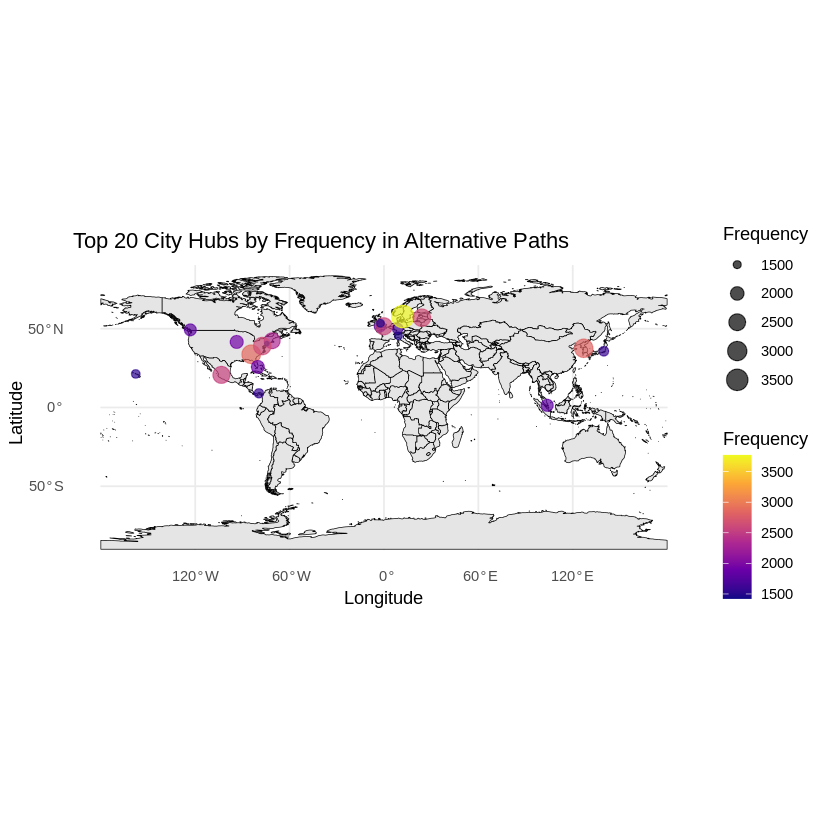

In [26]:
# Plot the top 20 hubs on the world map
ggplot() +
  geom_sf(data=the_world, fill="grey90", color="black", size=0.2) +
  geom_point(data=top_hubs, aes(x=longitude, y=latitude, size=Frequency, color=Frequency), alpha=0.7) +
  scale_color_viridis_c(option="plasma") +
  labs(title="Top 20 City Hubs by Frequency in Alternative Paths",
       x="Longitude", y="Latitude", color="Frequency", size="Frequency") +
  theme_minimal()


# Save the top hubs data to a CSV file
write.csv(top_hubs, "top_20_hubs.csv", row.names = FALSE)
print("Top 20 hubs data saved to top_20_hubs.csv")

### 3. Compute the Average Number of Intermediate Nodes

To estimate path complexity, we calculate how many **intermediate nodes**
each detour (TIV) path passes through.

If a path consists of \( N \) nodes, then the number of intermediate nodes is \( N-2 \),
excluding the source and destination.


In [27]:
# Convert Alternative_path to a character vector
alternative_paths_char <- as.character(combined_data$Alternative_path)

# Compute the number of intermediate nodes per connection
# Split the string by spaces and subtract 2 for the source and destination nodes
combined_data$Num_intermediate_nodes <- sapply(strsplit(alternative_paths_char, " "), length) - 2


# Calculate the average number of intermediate nodes
avg_intermediate_nodes <- mean(combined_data$Num_intermediate_nodes, na.rm = TRUE)

# Print the result
cat("Average number of intermediate nodes per alternative path:", round(avg_intermediate_nodes, 2), "\n")

Average number of intermediate nodes per alternative path: 1.75 


# **TIV matrix per region**

# 🌐 Compute Regional TIV Matrix (2025)

In this experiment, we analyze the **distribution of TIVs** between
different world regions.

Each pair of regions (source → destination) is evaluated to determine:
1. The **average TIV gain (%)**, representing the mean latency reduction for detour paths.
2. The **TIV ratio**, indicating the percentage of links that exhibit TIV within or between regions.

This produces a *Region–Region Matrix* that summarizes how frequently and how strongly
each region benefits from detour routing.


## Regional TIV Gain (mean latency reduction)

### 1. Prepare dataset for regional analysis

In [28]:
combined_data_v2 = combined_data

In [29]:
combined_data_v2

From,To,Direct,Alternative,Improvement,Alternative_path,TIV_present,TIV_gain,id,title,location,state,country,state_abbv,continent,latitude,longitude,region_code,server_label,Num_intermediate_nodes
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
Accra,JoaoPessoa,279.0813,260.4000,18.6813333,245 127 164 1,TRUE,7.1740911,285,Accra,Accra,Greater Accra,Ghana,AA,5,5.6037,-0.187,af,af_11,2
Accra,Toronto,204.5738,188.8774,15.6963750,245 220 95 3,TRUE,8.3103503,285,Accra,Accra,Greater Accra,Ghana,AA,5,5.6037,-0.187,af,af_11,2
Accra,Tokyo,347.5229,307.0309,40.4920000,245 11 183 167 118 228 6,TRUE,13.1882502,285,Accra,Accra,Greater Accra,Ghana,AA,5,5.6037,-0.187,af,af_11,5
Accra,Auckland,396.2890,369.0752,27.2137083,245 127 164 8,TRUE,7.3734850,285,Accra,Accra,Greater Accra,Ghana,AA,5,5.6037,-0.187,af,af_11,2
Accra,Stockholm,141.5106,137.8806,3.6300000,245 11 10,TRUE,2.6327130,285,Accra,Accra,Greater Accra,Ghana,AA,5,5.6037,-0.187,af,af_11,1
Accra,Dallas,221.6955,217.4735,4.2219583,245 127 16 12,TRUE,1.9413664,285,Accra,Accra,Greater Accra,Ghana,AA,5,5.6037,-0.187,af,af_11,2
Accra,Boston,179.2765,178.1473,1.1291667,245 149 14,TRUE,0.6338387,285,Accra,Accra,Greater Accra,Ghana,AA,5,5.6037,-0.187,af,af_11,1
Accra,Miami,214.2836,208.0164,6.2671667,245 127 15,TRUE,3.0128231,285,Accra,Accra,Greater Accra,Ghana,AA,5,5.6037,-0.187,af,af_11,1
Accra,Washington,189.7562,184.5297,5.2265000,245 127 16,TRUE,2.8323359,285,Accra,Accra,Greater Accra,Ghana,AA,5,5.6037,-0.187,af,af_11,1


In [30]:
combined_data_v2 <- merge(
  combined_data_v2,
  servers[, c("name", "country")],
  by.x = "From", by.y = "name", all.x = TRUE
)
colnames(combined_data_v2)[colnames(combined_data_v2) == "country"] <- "country_from"

In [31]:
combined_data_v2 <- merge(
  combined_data_v2,
  servers[, c("name", "country")],
  by.x = "To", by.y = "name", all.x = TRUE
)
colnames(combined_data_v2)[colnames(combined_data_v2) == "country"] <- "country_to"

### 2. Assign Countries to Regions

Each country is grouped into one of nine **macro-regions**:
NorthAm, WestEurope, EastEurope, Au&NewZ, LatAm, Africa, MidEast, Hindustan, and ESEA.

This enables a continent-level analysis of TIV patterns across the Internet.


In [42]:
assign_region <- function(country) {
  if (country %in% c("United States", "Canada", "Mexico", "Puerto Rico", "Guatemala", "Panama", "Honduras", "Costa Rica"))
    return("NorthAm")

  if (country %in% c("United Kingdom", "France", "Germany", "Spain", "Greece", "Italy", "Netherlands",
                     "Belgium", "Switzerland", "Austria", "Sweden", "Norway", "Finland", "Denmark",
                     "Ireland", "Portugal", "Luxembourg", "Iceland", "Malta", "Isle of Man"))
    return("WestEurope")

  if (country %in% c("Poland", "Czech Republic", "Hungary", "Romania", "Bulgaria", "Slovakia",
                     "Croatia", "Serbia", "Ukraine", "Lithuania", "Latvia", "Estonia",
                     "Slovenia", "Kosovo", "Moldova", "Russia", "Georgia", "Albania"))
    return("EastEurope")

  if (country %in% c("Australia", "New Zealand"))
    return("Au&NewZ")

  if (country %in% c("Brazil", "Argentina", "Chile", "Colombia", "Peru", "Uruguay",
                     "Ecuador", "Venezuela", "Suriname"))
    return("LatAm")

  if (country %in% c("South Africa", "Egypt", "Nigeria", "Kenya", "Morocco", "Algeria",
                     "Tunisia", "Tanzania", "Ghana", "Uganda"))
    return("Africa")

  if (country %in% c("United Arab Emirates", "Saudi Arabia", "Israel", "Qatar", "Turkey", "Oman",
                     "Kuwait", "Lebanon", "Cyprus"))
    return("MidEast")

  if (country %in% c("India", "Pakistan", "Bangladesh"))
    return("Hindustan")

  if (country %in% c("Japan", "Singapore", "Malaysia", "Indonesia", "China", "Thailand",
                     "Vietnam", "Philippines", "South Korea", "Cambodia", "Taiwan", "Hong Kong", "Kazakhstan"))
    return("ESEA")

  return(NA)
}

# Merge with servers data to get country information for 'From' cities
combined_data_v2 <- merge(combined_data_v2, servers[, c("id", "country")], by.x = "id", by.y = "id", all.x = TRUE)
setnames(combined_data_v2, "country", "country_from")

# Merge with servers data to get country information for 'To' cities
combined_data_v2 <- merge(combined_data_v2, servers[, c("name", "country")], by.x = "To", by.y = "name", all.x = TRUE)
setnames(combined_data_v2, "country", "country_to")


combined_data_v2$region_from <- sapply(combined_data_v2$country_from, assign_region)
combined_data_v2$region_to   <- sapply(combined_data_v2$country_to, assign_region)

Warning message in merge.data.frame(combined_data_v2, servers[, c("name", "country")], :
“column name ‘country_from’ is duplicated in the result”


In [43]:
names(combined_data_v2) <- make.unique(names(combined_data_v2))

### 3. Compute Regional TIV Gain Ratios**

For each region pair $(R_s, R_d)$, compute:
$$\text{AvgGain}(R_s, R_d) = \frac{1}{N} \sum_{i \in R_s, j \in R_d} G(i,j)$$
This shows how much latency improvement (in %) each region achieves on average
when routing traffic via detour paths.


In [44]:
region_matrix_df <- combined_data_v2 %>%
  filter(!is.na(region_from) & !is.na(region_to)) %>%
  group_by(region_from, region_to) %>%
  summarise(
    total_links = n(),
    tiv_links = sum(TIV_gain, na.rm = TRUE),
    tiv_av_TIV_gain = tiv_links / total_links  # percentage
  ) %>%
  ungroup()

`summarise()` has grouped output by 'region_from'. You can override using the
`.groups` argument.


### 4. Create the Regional Matrix

The aggregated table is reshaped into a Region–Region **matrix format**
for easy visualization and export.


In [45]:
region_matrix <- region_matrix_df %>%
  pivot_wider(names_from = region_to, values_from = tiv_av_TIV_gain) %>%
  as.data.frame()

In [46]:
df_sorted <- combined_data_v2 %>%
  arrange(desc(TIV_gain))

In [47]:
df_sorted

To,id,From,Direct,Alternative,Improvement,Alternative_path,TIV_present,TIV_gain,title,⋯,server_label,Num_intermediate_nodes,country.y,country_to,country_from,country_to.1,region_from,region_to,country_from.1,country_to.2
<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<chr>,⋯,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Toronto,184,Pittsburgh,98.48196,11.84850,86.63346,171 95 3,TRUE,731.1766,Pittsburgh,⋯,n_72,1,United States,Canada,United States,Canada,NorthAm,NorthAm,United States,Canada
Pittsburgh,2,Toronto,98.86400,12.20142,86.66258,3 95 171,TRUE,710.2666,Toronto,⋯,n_1,1,Canada,United States,Canada,United States,NorthAm,NorthAm,Canada,United States
Shanghai,72,HongKong,298.79433,37.80354,260.99079,71 94 169,TRUE,690.3871,Hong Kong,⋯,as_7,1,Hong Kong,China,Hong Kong,China,ESEA,ESEA,Hong Kong,China
HongKong,180,Shanghai,298.63833,37.81458,260.82375,169 94 71,TRUE,689.7438,Shanghai,⋯,as_16,1,China,Hong Kong,China,Hong Kong,ESEA,ESEA,China,Hong Kong
Hangzhou,72,HongKong,316.65450,45.71454,270.93996,71 94 83,TRUE,592.6778,Hong Kong,⋯,as_7,1,Hong Kong,China,Hong Kong,China,ESEA,ESEA,Hong Kong,China
HongKong,84,Hangzhou,316.24121,45.90000,270.34121,83 94 71,TRUE,588.9787,Hangzhou,⋯,as_8,1,China,Hong Kong,China,Hong Kong,ESEA,ESEA,China,Hong Kong
Hangzhou,112,Manila,354.84379,62.60721,292.23658,111 71 94 83,TRUE,466.7779,Manila,⋯,as_10,2,Philippines,China,Philippines,China,ESEA,ESEA,Philippines,China
Manila,84,Hangzhou,354.55983,62.95217,291.60767,83 94 71 111,TRUE,463.2210,Hangzhou,⋯,as_8,2,China,Philippines,China,Philippines,ESEA,ESEA,China,Philippines
HongKong,261,Zhangjiakou,333.57633,63.38517,270.19117,241 94 71,TRUE,426.2688,Zhangjiakou,⋯,as_21,1,China,Hong Kong,China,Hong Kong,ESEA,ESEA,China,Hong Kong


In [48]:
region_matrix_df

region_from,region_to,total_links,tiv_links,tiv_av_TIV_gain
<chr>,<chr>,<int>,<dbl>,<dbl>
Africa,Africa,59,1652.72423,28.012275
Africa,Au&NewZ,86,1316.39563,15.306926
Africa,ESEA,196,4683.75146,23.896691
Africa,EastEurope,207,3392.37830,16.388301
Africa,Hindustan,70,2400.89060,34.298437
Africa,LatAm,102,895.08617,8.775355
Africa,MidEast,88,1251.84344,14.225494
Africa,NorthAm,737,6083.18233,8.253979
Africa,WestEurope,429,6387.00180,14.888116


### 5. Visualize as Heatmap

This heatmap displays the **average TIV gain (%)** between each pair of regions.
Bright yellow areas indicate regions that experience the highest relative RTT reductions.


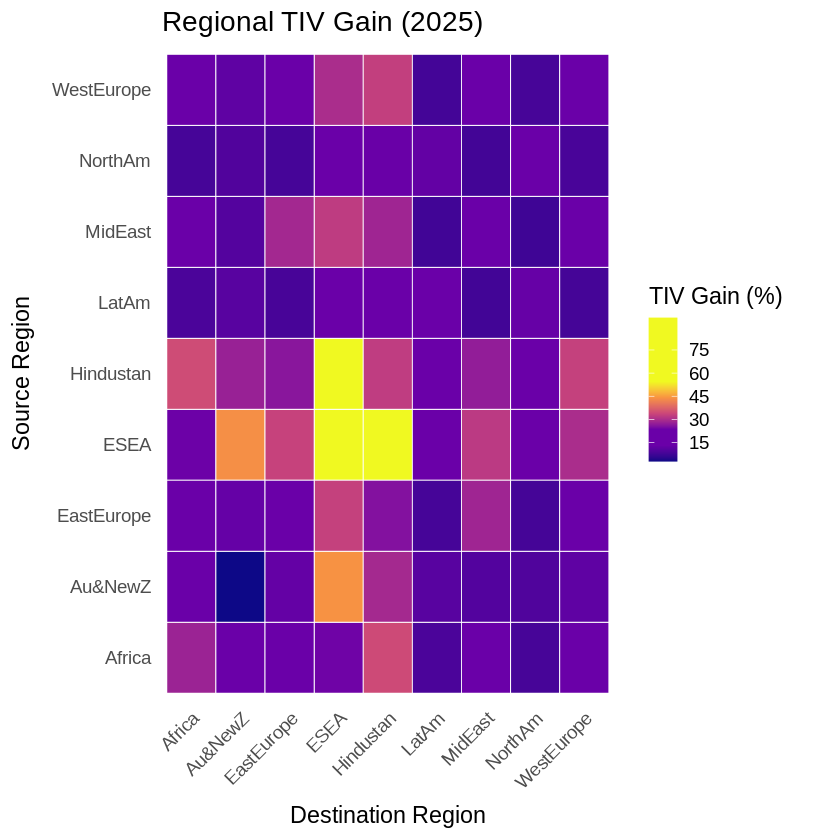

In [49]:
ggplot(region_matrix_df, aes(x = region_to, y = region_from, fill = tiv_av_TIV_gain)) +
  geom_tile(color = "white") +
  scale_fill_gradientn(
    name = "TIV Gain (%)",

    colours = c(
      "#0D0887",  # deep blue
      "#6A00A8",
      "#6A00A8",  # violet
      "#CB4679",  # magenta
      "#F89441",  # orange
      "#F0F921",
      "#F0F921",
      "#F0F921",
      "#F0F921" ,
      "#F0F921"   # yellow
    ),
    breaks = seq(0, 80, by = 15),          # consistent tick spacing

  ) +
  labs(
    title = "Regional TIV Gain (2025)",
    x = "Destination Region",
    y = "Source Region"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    panel.grid = element_blank()
  )



### 6. Export Matrix Data

In [52]:
region_matrix_clean_df <- combined_data_v2 %>%
  filter(!is.na(region_from) & !is.na(region_to)) %>%
  group_by(region_from, region_to) %>%
  summarise(
    tiv_av_TIV_gain = mean(TIV_gain, na.rm = TRUE)
  ) %>%
  ungroup()

region_matrix <- region_matrix_clean_df %>%
  pivot_wider(
    names_from = region_to,
    values_from = tiv_av_TIV_gain
  ) %>%
  arrange(match(region_from, unique(region_from)))  # optional row ordering

region_matrix

# Create the output directory if it doesn't exist
if (!dir.exists("output_files")) {
  dir.create("output_files")
}

write.csv(region_matrix_df, "output_files/Regional_TIV_Gain_Matrix.csv", row.names = FALSE)

`summarise()` has grouped output by 'region_from'. You can override using the
`.groups` argument.


region_from,Africa,Au&NewZ,ESEA,EastEurope,Hindustan,LatAm,MidEast,NorthAm,WestEurope
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Africa,28.012275,15.306926,23.89669,16.388301,34.29844,8.775355,14.225494,8.253979,14.888116
Au&NewZ,15.226352,2.805680,43.92151,12.327034,29.07709,10.546598,9.915427,9.491074,11.477487
ESEA,23.623435,43.433809,95.83059,33.175762,60.09121,14.446351,31.798459,14.148963,29.718155
EastEurope,16.607990,12.451270,32.89153,21.636003,25.56224,8.064110,28.466761,7.932103,15.952812
Hindustan,34.499884,27.734243,59.91998,26.207404,32.21929,14.206768,27.113021,13.300775,32.895124
LatAm,8.783386,10.608149,14.42450,8.321607,14.06123,20.934096,7.564327,12.585849,7.977305
MidEast,13.771752,9.935931,32.19837,28.905710,28.46769,7.448766,16.700465,7.263109,17.104038
NorthAm,8.062669,9.549267,14.49853,8.168919,12.98320,12.058335,7.677647,18.397133,8.507305
WestEurope,13.751614,11.479580,29.68598,16.110957,32.68774,7.828228,16.952357,8.273759,21.927715


## Regional TIV Ratio (Percentage of Links Exhibiting TIV)

In this experiment, we compute the **TIV Ratio** between world regions.  
For each source region $R_s$ and destination region $R_d$, the TIV ratio is defined as:

$$
\rho(R_s, R_d) = \frac{N_{\text{TIV}}(R_s, R_d)}{N_{\text{total}}(R_s, R_d)} \times 100\%
$$

where:

- $N_{\text{TIV}}(R_s, R_d)$ = number of source–destination links that exhibited a TIV  
- $N_{\text{total}}(R_s, R_d)$ = total number of measured links between the two regions  

This matrix highlights **where in the world TIVs are most common**, complementing the earlier matrix of **average TIV gain **.



### 1. Compute TIV Ratio per Region Pair

In [53]:
combined_data_v2 <- alternative_paths_all_data


combined_data_v2 <- merge(
  combined_data_v2,
  servers[, c("name", "country")],
  by.x = "From", by.y = "name", all.x = TRUE
)
colnames(combined_data_v2)[colnames(combined_data_v2) == "country"] <- "country_from"

combined_data_v2 <- merge(
  combined_data_v2,
  servers[, c("name", "country")],
  by.x = "To", by.y = "name", all.x = TRUE
)
colnames(combined_data_v2)[colnames(combined_data_v2) == "country"] <- "country_to"

combined_data_v2$region_from <- sapply(combined_data_v2$country_from, assign_region)
combined_data_v2$region_to   <- sapply(combined_data_v2$country_to, assign_region)

region_matrix_df <- combined_data_v2 %>%
  filter(!is.na(region_from) & !is.na(region_to)) %>%
  group_by(region_from, region_to) %>%
  summarise(
    total_links = n(),
    tiv_links = sum(TIV_present, na.rm = TRUE),
    tiv_ratio = tiv_links / total_links * 100  # percentage
  ) %>%
  ungroup()

`summarise()` has grouped output by 'region_from'. You can override using the
`.groups` argument.


In [54]:
#region_matrix <- region_matrix_df %>%
#  pivot_wider(names_from = region_to, values_from = tiv_ratio) %>%
#  as.data.frame()

region_matrix <- region_matrix_df %>%
  select(region_from, region_to, tiv_ratio) %>%
  pivot_wider(
    id_cols = region_from,
    names_from = region_to,
    values_from = tiv_ratio
  ) %>%
  arrange(match(region_from, unique(region_matrix_df$region_from)))

region_matrix

region_from,Africa,Au&NewZ,ESEA,EastEurope,Hindustan,LatAm,MidEast,NorthAm,WestEurope
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Africa,53.63636,86.86869,84.84848,69.69697,79.54545,77.27273,80.00000,80.72289,60.00000
Au&NewZ,85.85859,19.44444,78.83598,79.83539,80.55556,75.92593,91.11111,82.06158,82.90598
ESEA,84.84848,79.36508,66.19048,78.13051,75.59524,76.19048,88.57143,83.59151,83.88278
EastEurope,69.02357,79.01235,78.65961,43.01994,85.64815,71.91358,73.70370,73.53860,55.84046
Hindustan,78.40909,80.55556,76.19048,86.57407,39.28571,80.20833,92.50000,88.55422,85.96154
LatAm,84.09091,82.40741,82.14286,76.54321,89.58333,30.30303,89.16667,72.08835,83.20513
MidEast,76.36364,90.00000,87.61905,71.85185,87.50000,84.16667,71.11111,85.42169,73.23077
NorthAm,80.28478,82.46319,84.05049,73.76171,87.80120,71.28514,86.26506,55.67147,77.25672
WestEurope,60.27972,82.39316,84.17582,55.32764,84.61538,81.28205,76.30769,77.31233,52.69231


### 2. Visualize TIV Ratios as Heatmap

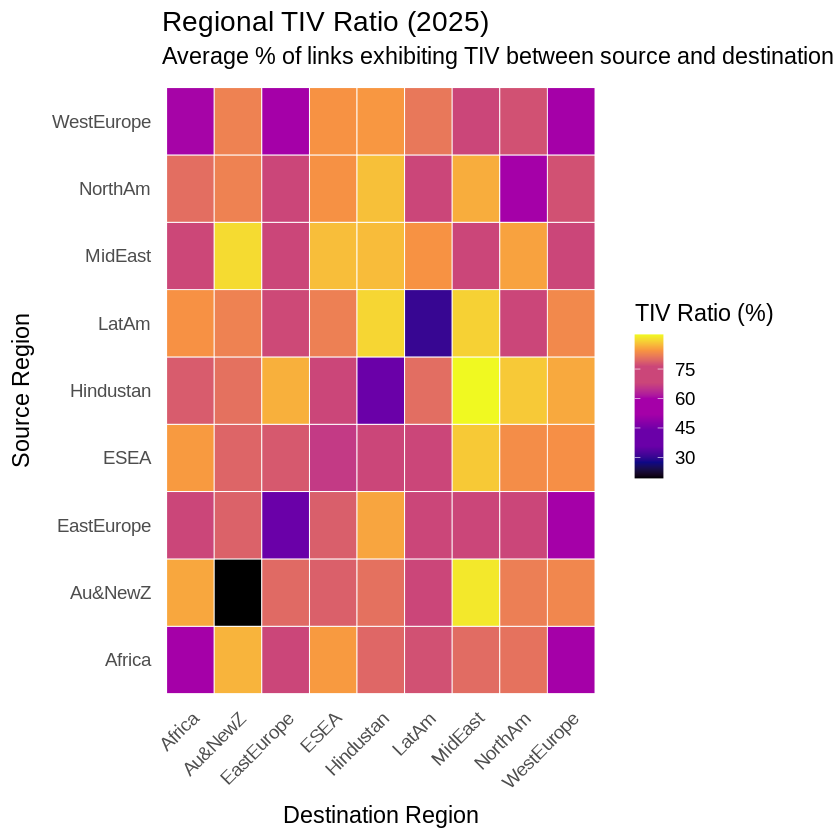

In [55]:
############################################################
# 5. Optional: visualize as heatmap
############################################################

ggplot(region_matrix_df, aes(x = region_to, y = region_from, fill = tiv_ratio)) +
  geom_tile(color = "white") +
  scale_fill_gradientn(
    name = "TIV Ratio (%)",
    colours = c(
      "black",
      "#0D0887",  # deep blue
      "#6A00A8",
      "#6A00A8",
      "#A500A8",  # violet#
      "#A500A8",  # violet
      "#CB4679",
      "#CB4679",  # magenta
      "#F89441",  # orange
      "#F0F921"   # yellow
    ),
    breaks = seq(0, 80, by = 15),          # consistent tick spacing

  ) +
  labs(
    title = "Regional TIV Ratio (2025)",
    subtitle = "Average % of links exhibiting TIV between source and destination regions",
    x = "Destination Region",
    y = "Source Region"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    panel.grid = element_blank()
  )



### 3. Export Data

In [56]:
write.csv(region_matrix_df, "output_files/Regional_TIV_Ratio_Matrix.csv", row.names = FALSE)